# Working with ERA5 wind data

## Importing data from netCDF format

In [58]:
import netCDF4 as nc
fn = '../raw_data/cedric_arabia_winds_test.nc'
ds = nc.Dataset(fn)

We can check the dimensions of the data. This file contains monthly averages of wind direction and strength for the Arabian Peninsula:

In [59]:
for dim in ds.dimensions.values():
    print(dim)

<class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 131
<class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 91
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 123


In [60]:
# These are the variables present - u and v are the two we are after:
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (131,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (91,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (123,)
filling on, default _FillValue of -2147483647 used
<class 'netCDF4._netCDF4.Variable'>
int16 u10(time, latitude, longitude)
    scale_factor: 0.000197534076701792
    add_offset: 1.2810725548305455
    _FillValue: -32767
    missing_value: -32767
    units: m s**-1
    long_name: 10 metre U wind component
unlimited dimensions: 
current shape = (123, 91, 131)
filling on
<

In [61]:
print(ds['u10'].shape)

(123, 91, 131)


In [62]:
v10 = ds['v10'][:]
u10 = ds['u10'][:]

## Converting to pandas using xarray

In [63]:
import xarray as xr

ds = xr.open_dataset(fn)
df = ds.to_dataframe()

In [64]:
# Drop NaN and display:
clean_df = df.dropna().reset_index()
clean_df

,latitude,longitude,time,u10,v10
0,25.0,44.000000,2011-01-01,-0.979902,1.709097
1,25.0,44.000000,2011-02-01,0.387033,0.880594
2,25.0,44.000000,2011-03-01,-0.474610,0.564273
3,25.0,44.000000,2011-04-01,0.031472,1.214827
4,25.0,44.000000,2011-05-01,0.146239,0.340970
...,...,...,...,...,...
1343647,16.0,52.099998,2020-11-01,-1.581789,-0.090903
1343648,16.0,52.099998,2020-12-01,-0.244483,-1.242372
1343649,16.0,52.099998,2021-01-01,0.086782,-0.812232
1343650,16.0,52.099998,2021-02-01,-0.958174,0.141933


In [65]:
print(f"Nb lats:{clean_df.latitude.nunique()}")
print(f"Nb long:{clean_df.longitude.nunique()}")
print(f"Nb of cells/images:{(clean_df.longitude.nunique()-1)*(clean_df.latitude.nunique()-1)}")

Nb lats:91
Nb long:131
Nb of cells/images:11700


## Calculating wind direction and strength

So now we have a nice Pandas Dataframe with wind data in u and v vector format, one datapoint per gridcell per month since 2011. Let's calculate a few property of interest for our project, starting with the wind strenght.

### Wind Strength
A good article on how to do this <a href='http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv'>can be seen here</a>.

In [66]:
import numpy as np

clean_df['wind strength (m/s)'] = (clean_df.u10**2 + clean_df.v10**2)**.5
clean_df

,latitude,longitude,time,u10,v10,wind strength (m/s)
0,25.0,44.000000,2011-01-01,-0.979902,1.709097,1.970082
1,25.0,44.000000,2011-02-01,0.387033,0.880594,0.961894
2,25.0,44.000000,2011-03-01,-0.474610,0.564273,0.737332
3,25.0,44.000000,2011-04-01,0.031472,1.214827,1.215234
4,25.0,44.000000,2011-05-01,0.146239,0.340970,0.371007
...,...,...,...,...,...,...
1343647,16.0,52.099998,2020-11-01,-1.581789,-0.090903,1.584399
1343648,16.0,52.099998,2020-12-01,-0.244483,-1.242372,1.266199
1343649,16.0,52.099998,2021-01-01,0.086782,-0.812232,0.816855
1343650,16.0,52.099998,2021-02-01,-0.958174,0.141933,0.968629


### Wind direction
We can use the arctan2 function in Numpy to calculate the angle of the wind in Radians. For easy of interpretation I convert it here to degrees, but this is not strictly necessary.

In [67]:
clean_df['wind direction (degrees from North)'] = np.degrees(np.arctan2(clean_df['u10'],clean_df['v10']))
clean_df


,latitude,longitude,time,u10,v10,wind strength (m/s),wind direction (degrees from North)
0,25.0,44.000000,2011-01-01,-0.979902,1.709097,1.970082,-29.827585
1,25.0,44.000000,2011-02-01,0.387033,0.880594,0.961894,23.726149
2,25.0,44.000000,2011-03-01,-0.474610,0.564273,0.737332,-40.067226
3,25.0,44.000000,2011-04-01,0.031472,1.214827,1.215234,1.484004
4,25.0,44.000000,2011-05-01,0.146239,0.340970,0.371007,23.214113
...,...,...,...,...,...,...,...
1343647,16.0,52.099998,2020-11-01,-1.581789,-0.090903,1.584399,-93.289085
1343648,16.0,52.099998,2020-12-01,-0.244483,-1.242372,1.266199,-168.867157
1343649,16.0,52.099998,2021-01-01,0.086782,-0.812232,0.816855,173.901459
1343650,16.0,52.099998,2021-02-01,-0.958174,0.141933,0.968629,-81.574135


### Sin/Cosin of wind direction

We need the Sin/Cosin of our wind direction as one of our labels:

In [68]:
clean_df['SinDir'] = np.sin(np.arctan2(clean_df['u10'],clean_df['v10']))
clean_df['CosDir'] = np.cos(np.arctan2(clean_df['u10'],clean_df['v10']))
clean_df

,latitude,longitude,time,u10,v10,wind strength (m/s),wind direction (degrees from North),SinDir,CosDir
0,25.0,44.000000,2011-01-01,-0.979902,1.709097,1.970082,-29.827585,-0.497392,0.867526
1,25.0,44.000000,2011-02-01,0.387033,0.880594,0.961894,23.726149,0.402366,0.915479
2,25.0,44.000000,2011-03-01,-0.474610,0.564273,0.737332,-40.067226,-0.643686,0.765290
3,25.0,44.000000,2011-04-01,0.031472,1.214827,1.215234,1.484004,0.025898,0.999665
4,25.0,44.000000,2011-05-01,0.146239,0.340970,0.371007,23.214113,0.394168,0.919038
...,...,...,...,...,...,...,...,...,...
1343647,16.0,52.099998,2020-11-01,-1.581789,-0.090903,1.584399,-93.289085,-0.998353,-0.057374
1343648,16.0,52.099998,2020-12-01,-0.244483,-1.242372,1.266199,-168.867157,-0.193084,-0.981182
1343649,16.0,52.099998,2021-01-01,0.086782,-0.812232,0.816855,173.901459,0.106239,-0.994341
1343650,16.0,52.099998,2021-02-01,-0.958174,0.141933,0.968629,-81.574135,-0.989206,0.146530


## Aggregating data

What we have now is a large dataframe with data for each month over 10 years, but what we need is one single metric. We could use the mean value:

In [69]:
clean_df.groupby(by=['latitude','longitude']).mean().reset_index()

,latitude,longitude,u10,v10,wind strength (m/s),wind direction (degrees from North),SinDir,CosDir
0,16.0,44.000000,-0.181046,-0.161718,0.957105,-31.121567,-0.165972,-0.226051
1,16.0,44.099998,-0.331522,-0.194373,1.168922,-30.583496,-0.252045,-0.178132
2,16.0,44.200001,-0.368120,-0.203500,1.233255,-27.637665,-0.288860,-0.172874
3,16.0,44.299999,-0.258468,-0.181616,1.107670,-28.578266,-0.340324,-0.162151
4,16.0,44.400002,-0.147194,-0.163430,1.023259,-26.020409,-0.349655,-0.146004
...,...,...,...,...,...,...,...,...
10919,25.0,55.900002,0.254342,0.147504,1.148086,5.843815,0.089418,0.125889
10920,25.0,56.000000,0.319425,0.086278,1.181427,12.968260,0.122568,0.113371
10921,25.0,56.099998,0.372967,0.034705,1.233853,15.066347,0.125996,0.071222
10922,25.0,56.200001,0.264522,0.063788,1.214530,16.372971,0.113589,0.103966


Or the maximum value of wind strength:

In [73]:
max_idx = clean_df.groupby(by=['latitude','longitude'])['wind strength (m/s)'].transform(max) == clean_df['wind strength (m/s)']

clean_df[max_idx]

,latitude,longitude,time,u10,v10,wind strength (m/s),wind direction (degrees from North),SinDir,CosDir
79,25.0,44.000000,2017-08-01,-1.506726,-2.858068,3.230910,-152.202545,-0.466347,-0.884602
204,25.0,44.099998,2017-10-01,-0.093962,3.145978,3.147381,-1.710768,-0.029854,0.999554
327,25.0,44.200001,2017-10-01,-0.164679,3.093402,3.097782,-3.047304,-0.053160,0.998586
450,25.0,44.299999,2017-10-01,-0.237965,3.044582,3.053867,-4.469152,-0.077922,0.996959
537,25.0,44.400002,2014-10-01,-0.610316,2.950118,3.012588,-11.688381,-0.202589,0.979264
...,...,...,...,...,...,...,...,...,...
1343048,16.0,51.700001,2011-12-01,1.577571,-2.037076,2.576511,142.244751,0.612290,-0.790633
1343171,16.0,51.799999,2011-12-01,1.643943,-2.063075,2.637959,141.450729,0.623187,-0.782073
1343294,16.0,51.900002,2011-12-01,1.689375,-2.083008,2.681960,140.957016,0.629903,-0.776674
1343417,16.0,52.000000,2011-12-01,1.735203,-2.102941,2.726406,140.472855,0.636444,-0.771323


And finally we can extract the values corresponding to the mode of the wind data if we wanted:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

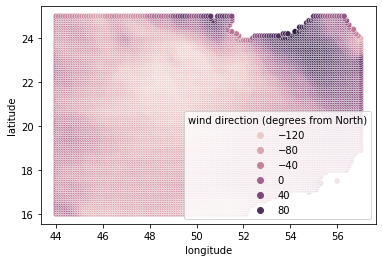

In [83]:
import seaborn as sns
mean_data = clean_df.groupby(by=['latitude','longitude']).mean().reset_index()
sns.scatterplot(data=mean_data, y='latitude', x='longitude',hue='wind direction (degrees from North)')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

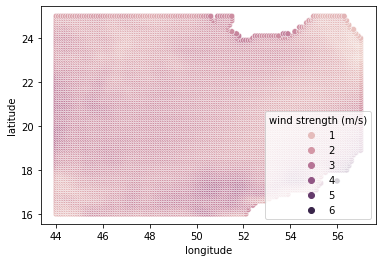

In [84]:
sns.scatterplot(data=mean_data, y='latitude', x='longitude',hue='wind strength (m/s)')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

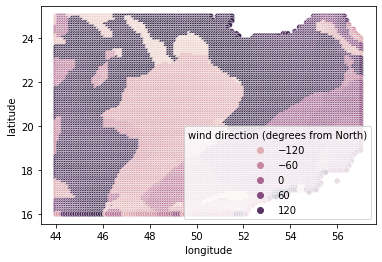

In [85]:
max_data = clean_df[max_idx]
sns.scatterplot(data=max_data, y='latitude', x='longitude',hue='wind direction (degrees from North)')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

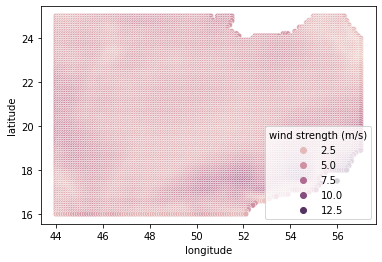

In [86]:
sns.scatterplot(data=max_data, y='latitude', x='longitude',hue='wind strength (m/s)')